# INTRODUCTION

* **Goal**
    
    * The goal becomes to find a personalized tastes.

* **Scoring Approach**

    * For **training** purpose, dot product of embedding layers of users and movies are used.
    * For **inference** purpose, 
        * Top 3 most similar customers are identified based **cosine distance** of user and mvoies embedding matrices.
        * Normalized ratings of similar customers are taken.
        * Expected rating, $r_{a,i}^{cos}$, of the movie $i$ by the customer $a$ is calculated as follows: $${r_{a,i}^{cos} = \frac{\sum_{b}r_{b,i}^{cos} \times sim(a,b)}{\sum_{b}sim(a,b)}}$$ where $b$ is list of most similar customers. $sim(a,b)$ is the similarity metric which is inverse of cosine distance. $$sim(a,b) = \frac{1}{cosdist(a,b)}$$
        * $r_{a,i}^{model}$ is the expected rating which is calculated by deep learning model.
        * Final suggestion is calculated based on values of $$r^{final}_{a,i} = r^{model}_{a,i} + r^{cos}_{a,i} $$
    

* **Limitations**
    * It is assumed that inference is done only for the rated movies and by the users who already rated.

# LIBRARIES

In [1]:
import pandas as pd

import numpy as np

from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from Movie_Recommender import SourceData, PreProcessing, DeepLearning, Recommendation

In [2]:
np.set_printoptions(suppress=True)

# DATA SOURCE

Data is downloaded from the link https://www.kaggle.com/datasets/san1201/movielens1m?select=ml-1m.train.csv

## Users

In [3]:
dfUsers = SourceData.dfGetUsers()
dfCopyUsers = dfUsers.copy()
dfUsers.head()

,gender,age,occupation,zip_code
user_id,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455


## Movies

In [4]:
dfMovies = SourceData.dfGetMovies()
dfCopyMovies = dfMovies.copy()
dfMovies.head()

,title,genres
movie_id,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


## Ratings

In [5]:
dfRatings = SourceData.dfGetRatings()
dfCopyRatings = dfRatings.copy()
dfRatings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# PREPROCESSING

## Extract Year of Release of Movies

After moving the ""year_of_release"" from ""title"" there can be duplicated names. It means that same movie name has different release years. (e.g., <i>Hamlet</i>)

In [6]:
dfMovies = PreProcessing.dfExtractYearOfReleaseOfMovies(dfMovies)

In [7]:
dfMovies[dfMovies['title'] == 'Hamlet']

,title,genres,year_of_release
movie_id,,,
1411,Hamlet,Drama,1996
1941,Hamlet,Drama,1948
2820,Hamlet,Drama,1964
3598,Hamlet,Drama,2000
3723,Hamlet,Drama,1990


## Transform Genres of Movies to One Hot Vector

In [8]:
dfMovies = PreProcessing.dfTransformGenresToOneHot(dfMovies)
dfMovies

,title,genres,year_of_release,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,Animation|Children's|Comedy,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji,Adventure|Children's|Fantasy,1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men,Comedy|Romance,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale,Comedy|Drama,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Father of the Bride Part II,Comedy,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,Meet the Parents,Comedy,2000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3949,Requiem for a Dream,Drama,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3950,Tigerland,Drama,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Merge Datasets

In [9]:
dfPreprocessed = PreProcessing.dfMergeRatingsMoviesUsers(dfRatings, dfMovies, dfUsers)

## Encode Movie ID and Item Id in Ratings Dataset

In [10]:
dfPreprocessed = PreProcessing.oEncodeField(dfPreprocessed, 'movie_id', 'Ordinal')
dfPreprocessed = PreProcessing.oEncodeField(dfPreprocessed, 'user_id', 'Ordinal')
dfPreprocessed = PreProcessing.oEncodeField(dfPreprocessed, 'gender', 'Label')
dfPreprocessed = PreProcessing.oEncodeField(dfPreprocessed, 'age', 'MinMax')
dfPreprocessed = PreProcessing.oEncodeField(dfPreprocessed, 'year_of_release', 'MinMax')

C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# DEEP LEARNING MODEL

## Split Train-Validation-Test

70%-15%-15% of ratings are used as ratio to identify train, validation and test datasets. Data is shuffled before splitting.

In [11]:
ixTrain, ixValidation , ixTest = DeepLearning.ixSplitTrainValidationTest(dfPreprocessed)

## Identify Unique Number of Movies and Users in Ratings Dataset

In [12]:
iNrOfMovies, iNrOfUsers = DeepLearning.iGetNrOfUniqueMoviesUsers(dfPreprocessed)

## Build Input Datasets

Embedding layer is not generated only user id and movie id but also following columns: 
* movie_id_encoded,
* user_id_encoded,
* year_of_release_encoded,
* age_encoded,
* gender_encoded,
* Action, 
* Adventure, 
* Animation,
* Children's, 
* Comedy, 
* Crime, 
* Documentary, 
* Drama, 
* Fantasy, 
* Film-Noir, 
* Horror, 
* Musical, 
* Mystery, 
* Romance, 
* Sci-Fi, 
* Thriller, 
* War,
* Western

In [13]:
aMovie_X_Train, aMovie_X_Validation, aMovie_X_Test, aUser_X_Train, aUser_X_Validation, aUser_X_Test = DeepLearning.aBuildInputDatasets(dfPreprocessed, ixTrain, ixValidation, ixTest)

In [27]:
aMovie_X_Train

array([[3341.        ,    1.        ,    0.        , ...,    1.        ,
           0.43636364,    1.        ],
       [2183.        ,    1.        ,    0.        , ...,    0.81481481,
           0.43636364,    1.        ],
       [1104.        ,    0.        ,    0.        , ...,    0.69135802,
           0.61818182,    1.        ],
       ...,
       [3049.        ,    0.        ,    0.        , ...,    1.        ,
           0.8       ,    1.        ],
       [3041.        ,    1.        ,    0.        , ...,    0.90123457,
           0.61818182,    1.        ],
       [1537.        ,    0.        ,    0.        , ...,    0.81481481,
           0.89090909,    1.        ]])

## Build Output Datasets

Output dataset is one hot vector of rating.

In [14]:
a_y_Train, a_y_Validation, a_y_Test = DeepLearning.aBuildOutputDatasets(dfPreprocessed, ixTrain, ixValidation,ixTest)

## Tune Hyperparameters

Random search algorithm is applied to tune hyperparameters. 20 experiment is executed. Each experiment is executed 2 times. Early stopping is applied with 5 patience over validation loss. Batch size is 4096.

In [28]:
oTuner = DeepLearning.oTuneHyperparameters(iNrOfMovies, iNrOfUsers, aMovie_X_Train, aUser_X_Train, a_y_Train,aMovie_X_Validation, aUser_X_Validation , a_y_Validation)
oTuner.search_space_summary()

Search space summary
Default search space size: 6
embedding_size (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 8, 'sampling': None}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 5, 'step': 1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
l2_regulizer_coeff (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.005, 'step': None, 'sampling': None}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.005, 'step': None, 'sampling': None}


In [15]:
oTuner.results_summary()

Trial 20 Complete [00h 01m 32s]
val_loss: 0.4054022431373596

Best val_loss So Far: 0.3989855647087097
Total elapsed time: 00h 44m 30s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in Hyperparameter Optimization\Random Search
Showing 10 best trials
Trial summary
Hyperparameters:
embedding_size: 4
layers: 2
learning_rate: 0.008019213778778293
units: 8
l2_regulizer_coeff: 0.0
dropout_rate: 0.0
Score: 0.3989855647087097
Trial summary
Hyperparameters:
embedding_size: 44
layers: 1
learning_rate: 0.005802921287754577
units: 40
l2_regulizer_coeff: 0.0002967835480827885
dropout_rate: 0.004018860239440322
Score: 0.40533192455768585
Trial summary
Hyperparameters:
embedding_size: 12
layers: 4
learning_rate: 0.003381835445739296
units: 24
l2_regulizer_coeff: 0.0007296176460262472
dropout_rate: 0.0018159392669947322
Score: 0.4054022431373596
Trial summary
Hyperparameters:
embedding_size: 12
layers: 4
learning_rate: 0.004093525724795625
units: 32
l2_regulizer_coeff: 0.002756166201724

## Optimum Model

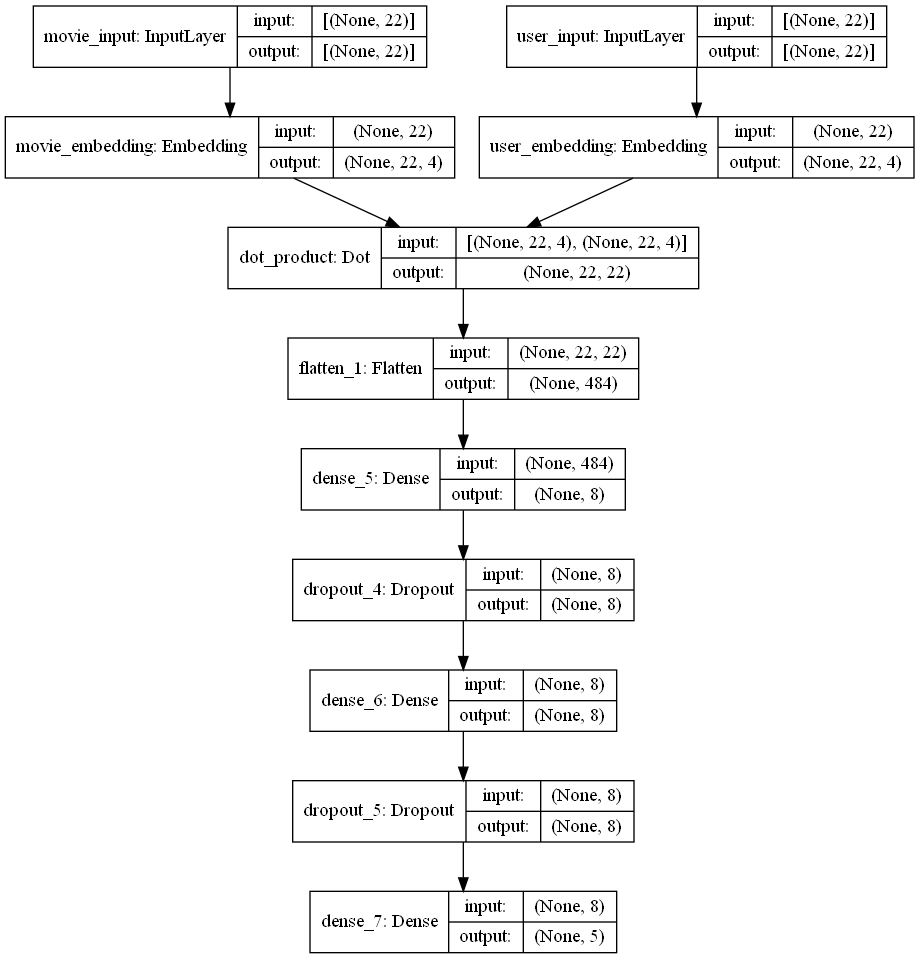

In [16]:
oOptimumModel = DeepLearning.oBuildModel(oTuner.get_best_hyperparameters(1)[0], iNrOfMovies=iNrOfMovies, iNrOfUsers=iNrOfUsers)
plot_model(oOptimumModel, show_shapes=True)

## Fit Model

Early stopping is applied with 5 patience over validation loss. Batch size is 4096.

In [17]:
dfHistory = DeepLearning.dfFitModel(oOptimumModel, aMovie_X_Train, aUser_X_Train,a_y_Train, aMovie_X_Validation, aUser_X_Validation, a_y_Validation)

Epoch 1/1000
171/171 [==============================] - 5s 20ms/step - loss: 0.4422 - val_loss: 0.4155
Epoch 2/1000
171/171 [==============================] - 3s 17ms/step - loss: 0.4135 - val_loss: 0.4126
Epoch 3/1000
171/171 [==============================] - 3s 17ms/step - loss: 0.4104 - val_loss: 0.4111
Epoch 4/1000
171/171 [==============================] - 3s 17ms/step - loss: 0.4082 - val_loss: 0.4100
Epoch 5/1000
171/171 [==============================] - 3s 17ms/step - loss: 0.4060 - val_loss: 0.4090
Epoch 6/1000
171/171 [==============================] - 3s 17ms/step - loss: 0.4043 - val_loss: 0.4086
Epoch 7/1000
171/171 [==============================] - 3s 17ms/step - loss: 0.4033 - val_loss: 0.4077
Epoch 8/1000
171/171 [==============================] - 3s 17ms/step - loss: 0.4019 - val_loss: 0.4075
Epoch 9/1000
171/171 [==============================] - 3s 18ms/step - loss: 0.4010 - val_loss: 0.4069
Epoch 10/1000
171/171 [==============================] - 3s 17ms/step - l

INFO:tensorflow:Assets written to: Models\rating_estimator_model\assets


INFO:tensorflow:Assets written to: Models\rating_estimator_model\assets


<AxesSubplot:ylabel='loss'>

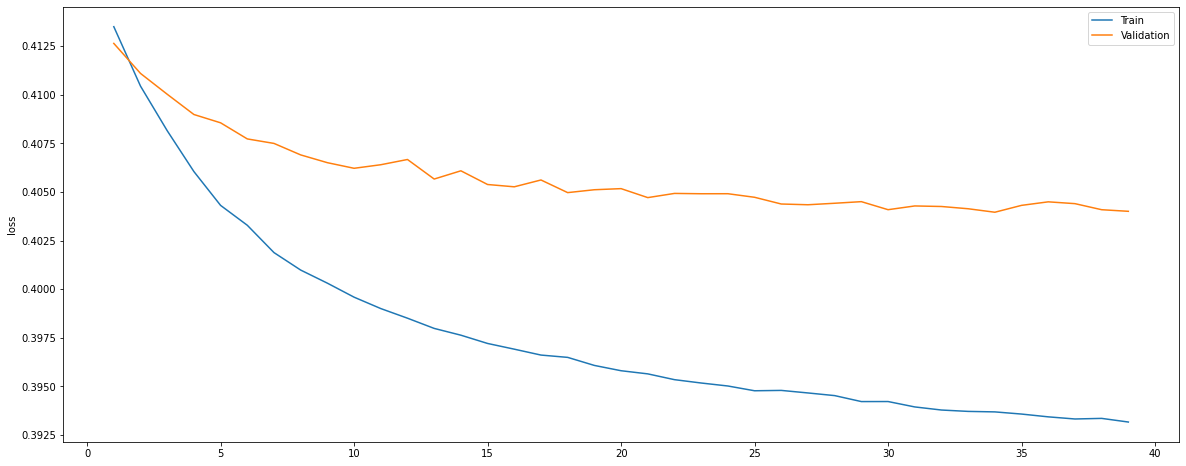

In [18]:
plt.figure(figsize = (20, 8))
sns.lineplot(data = dfHistory['loss'].iloc[1:], legend = True, label = 'Train')
sns.lineplot(data = dfHistory['val_loss'].iloc[1:], legend = True, label = 'Validation')

## Test Model

In [19]:
pred = DeepLearning.aPredict(aMovie_X_Test, aUser_X_Test, oOptimumModel)
ground_true = DeepLearning.aDecodeOutput(a_y_Test)

DeepLearning.dfGetRegressionMetrics(ground_true, pred)

,Value
Mean Squared Error,0.98
Root Mean Squared Error,0.99
Mean Absolute Error,0.67
R2 Score,0.22


              precision    recall  f1-score   support

           1       0.48      0.32      0.39      8296
           2       0.36      0.14      0.20     16164
           3       0.42      0.42      0.42     39446
           4       0.45      0.60      0.51     52153
           5       0.55      0.48      0.51     33973

    accuracy                           0.46    150032
   macro avg       0.45      0.39      0.41    150032
weighted avg       0.46      0.46      0.45    150032



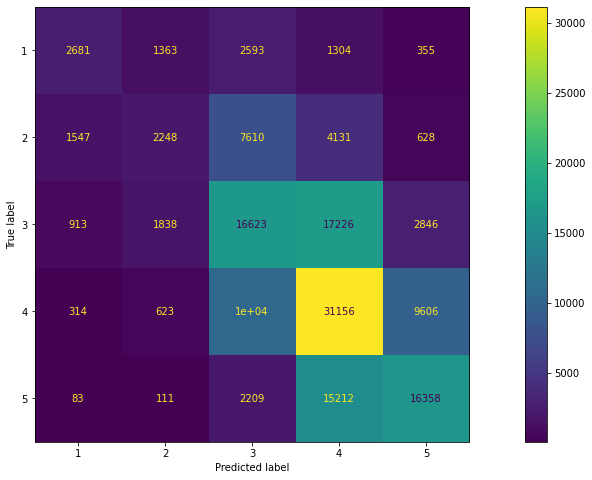

In [20]:
print(classification_report(ground_true, pred))

aConfMatr = confusion_matrix(ground_true, pred, labels = np.unique(ground_true))
oConfMatr = ConfusionMatrixDisplay(aConfMatr, display_labels  = np.unique(ground_true))
fig, ax = plt.subplots(figsize=(20,8))
oConfMatr.plot(ax=ax)

<AxesSubplot:ylabel='Count'>

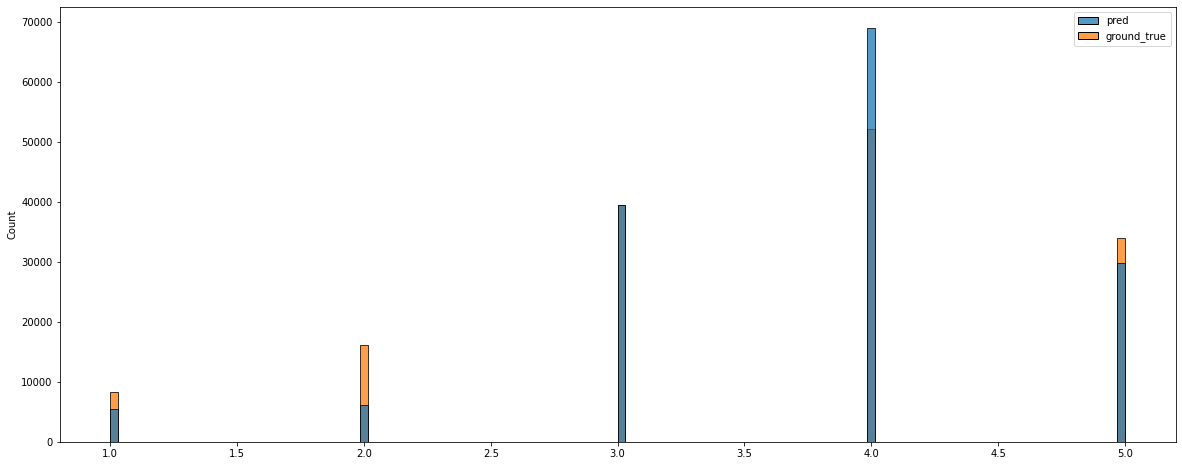

In [21]:
dfComparison = pd.DataFrame(index = ixTest)
dfComparison['pred'] = pred
dfComparison['ground_true'] = ground_true

plt.figure(figsize = (20, 8))
sns.histplot(data = dfComparison)

# RECOMMENDATION

The ones who has smallest **cosine** distance is the most similar to each other.

In [22]:
iUserID = 205

oRecommender = Recommendation(iUserID, dfPreprocessed)

In [23]:
aMaxSimilarNUsers = oRecommender.aGetMostSimilarUsers()

In [24]:
dfSimilarUserRatings = oRecommender.dfGetMovieIdsRatedByMostSimilarUsers(aMaxSimilarNUsers)
dfSimilarUserRatings = oRecommender.dfExcludeMovieIdsThatAreAlreadyRatedByUser(dfSimilarUserRatings)
dfSimilarUserRatings = oRecommender.dfGetExpectedRatingsForSimilarUserRatings(dfSimilarUserRatings)
dfSimilarUserRatings = oRecommender.dfCalculateFinalExpectedScores(dfSimilarUserRatings)


In [25]:
oRecommender.dfGetMoviesToRecommend(dfSimilarUserRatings)

,title,genres,expected_rating
0,"Crying Game, The (1992)",Drama|Romance|War,5.0
1,Parenthood (1989),Comedy|Drama,5.0
2,Local Hero (1983),Comedy,5.0
3,Say Anything... (1989),Comedy|Drama|Romance,5.0
4,Dangerous Liaisons (1988),Drama|Romance,5.0


## User History

In [26]:
oRecommender.dfGetUserHistory()

,title,genres,rating
152,Rosencrantz and Guildenstern Are Dead (1990),Comedy|Drama,5
60,"Ghost and Mrs. Muir, The (1947)",Drama|Romance,5
71,Beyond the Mat (2000),Documentary,5
132,"Big Blue, The (Le Grand Bleu) (1988)",Adventure|Romance,5
133,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama,5
...,...,...,...
96,"Little Shop of Horrors, The (1960)",Comedy|Horror,2
103,Mary Poppins (1964),Children's|Comedy|Musical,1
11,"Princess Mononoke, The (Mononoke Hime) (1997)",Action|Adventure|Animation,1
8,Stand by Me (1986),Adventure|Comedy|Drama,1


# IMPLEMENTATION

* **Scalibility** is a challage.
    * Spark cluster should be used for machine learning models.
    * Big data and cloud technologies should be used for databases, data streamings, virutal machines.
* It is challange for users who never rated before, or new user, or new movie etc...
    * There should be another machine learning algorithms to identify the cluster of customer via using features such as user interaction, search results, user profile etc.
    * Some nearline algorithms could be run after enough data is collected from user. Embedding, encoding models etc. could be updated.
    * Models should not be fully retrained. Instead, a trained weights could be applied as weight initialization.
    * Some rule based algorithims could be applied also to cluster customers/movies etc.

* **Latency** could be issue. User should be encouraged immidiately after making some searches.
    * Spark streaming, Kafka etc. can be used streaming based predicitons.
    * ElasticSearch integration can be used for search basis.
   
* Models can be outdated
    * Six sigma based, stastistical process control mechanisms could be used to monitor model performances.
    * Manual model verificiation might be needed.
    * A/B test can be applied.

* Imbalancade data could occur about rating.
    * Data oversampling/undersampling can be done. In this study, I have applied but it didn't give very good results.
    * Cross validation can be applied.
    
* CI/CD, ml-ops activities should be ensured so that they can be executed based on a framework.


# FUTURE STEPS

1. Book https://www.amazon.com/Recommender-Systems-Introduction-Dietmar-Jannach/dp/0521493366 should be read.
1. For Embedding layer of movies, vocabulary of **title** of movie can be used.
1. Sequence of user ratings is important. Sequence models can be used.
1. Don't recommend second version of series if the user did not watch the first ones.
1. **Singular Value Decomposition** can be applied. I applied, there were good results.

# REFERENCES

1. https://developers.google.com/machine-learning/clustering/similarity/supervised-similarity
1. https://towardsdatascience.com/recommender-systems-from-learned-embeddings-f1d12288f278#:~:text=Embeddings%20are%20vector%20representations%20of,and%20user%20IDs%20as%20embeddings.
1. https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429
1. https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-2-d9b96aa399f5
1. https://blog.tensorflow.org/2020/09/introducing-tensorflow-recommenders.html
1. http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf